# Change point based Clustering

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../')

In [5]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [6]:
from eval.tsdr import load_tsdr_by_chaos

tt_dataset_by_chaos = load_tsdr_by_chaos(
    TRAINTICKET_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [70]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-memory-hog", "carts-db")][2]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape, record.chaos_case_file()

carts-db/pod-memory-hog/9n6mf-2


((180, 1321),
 '2023-02-17-argowf-chaos-9n6mf-carts-db_pod-memory-hog_2.json of carts-db/pod-memory-hog')

In [71]:
from tsdr.outlierdetection.spot import detect_anomalies_with_spot
from tsdr.outlierdetection.n_sigma_rule import detect_anomalies_with_zscore_nsigma

sli_data: pd.DataFrame = dataset.loc[
    :, [col for col in record.pk.get_root_metrics() if col in dataset.columns]
]  # retrieve only existing slis
most_anomalous_sli_name = sli_data.apply(lambda x: detect_anomalies_with_spot(x.to_numpy(), 4*30)[1]).idxmax()
most_anomalous_sli_data = sli_data[most_anomalous_sli_name].to_numpy()
most_anomalous_sli_name 

's-front-end_latency'

In [72]:
cols = [record.pk.get_container_by_metric(metric) == record.chaos_comp() for metric in dataset.columns]
cause_dataset = dataset.loc[:, cols]

In [73]:
from tsdr.multireducer import change_point_clustering, change_point_clustering_with_kde
from tsdr.smooth import moving_average

In [74]:
# from tsdr import tsdr

# tsdr.Tsdr(enable_unireducer=False, enable_multireducer=True, univariate_series_func_or_name="residual_integral",
#     step2_clustering_method_name="changepoint",
#     step2_changepoint_n_bkps=1,
#     step2_changepoint_proba_threshold=0.5,
#     step2_clustering_choice_method="max_members_changepoint",
#     step2_changepoint_cluster_selection_method="leaf",
#     step2_changepoint_cluster_selection_epsilon=3.0,
#     step2_changepoint_allow_single_cluster=True,
#     step2_clustering_n_workers=1,
# ).reduce_multivariate_series(
#     dataset,
#     record.pk,
#     n_workers=1,
# )

In [75]:
# cinfo, remove_metrics = change_point_clustering(
#     cause_dataset,
#     n_bkps=1,
#     proba_threshold=0.5,
#     choice_method="max_members_changepoint",
#     cluster_selection_epsilon=3.0,
#     cluster_selection_method="leaf",
#     cluster_allow_single_cluster=True,
#     sli_data=sli_data,
#     n_jobs=-1,
# )
cinfo, remove_metrics = change_point_clustering_with_kde(
    cause_dataset,
    n_bkps=1,
    kde_bandwidth=0.1,
    n_jobs=-1,
)
cinfo, remove_metrics

({'m-carts-db_mongodb_sys_netstat_TcpExt_TCPOrigDataSent': [],
  'm-carts-db_mongodb_ss_wt_cursor_Total_number_of_entries_skipped_by_cursor_next_calls': [],
  'm-carts-db_mongodb_ss_wt_cache_modified_pages_evicted': [],
  'm-carts-db_mongodb_ss_wt_capacity_bytes_written_for_log': [],
  'm-carts-db_mongodb_ss_wt_log_log_records_too_small_to_compress': [],
  'm-carts-db_mongodb_ss_locks_FeatureCompatibilityVersion_acquireCount_w': [],
  'm-carts-db_mongodb_ss_wt_cursor_cursor_search_calls': [],
  'm-carts-db_mongodb_ss_wt_cache_hazard_pointer_blocked_page_eviction': [],
  'm-carts-db_mongodb_ss_wt_cache_pages_written_from_cache': [],
  'm-carts-db_mongodb_ss_tcmalloc_tcmalloc_pageheap_total_commit_bytes': [],
  'm-carts-db_mongodb_ss_wt_cursor_cursors_reused_from_cache': [],
  'm-carts-db_mongodb_ss_network_bytesIn': [],
  'm-carts-db_mongodb_ss_wt_txn_update_conflicts': [],
  'm-carts-db_mongodb_ss_wt_connection_auto_adjusting_condition_wait_calls': [],
  'm-carts-db_mongodb_ss_wt_curso

In [76]:
import ruptures as rpt
import hdbscan 
from hdbscan.prediction import all_points_membership_vectors, all_points_outlier_membership_vector

from collections import defaultdict
import itertools

In [77]:
# cause_dataset = cause_dataset.apply(lambda x: moving_average(x, window_size=5))
# sli_data = sli_data.apply(lambda x: moving_average(x, window_size=5))

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


161

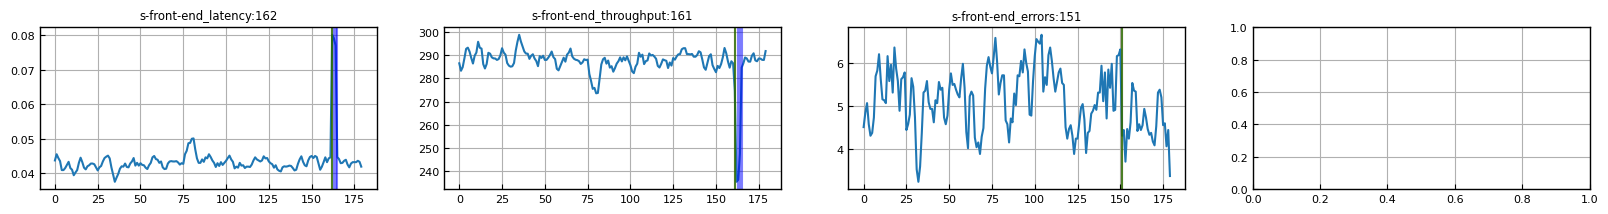

In [78]:
import math

binseg = rpt.Binseg(model="normal", jump=1)
fig, axs = plt.subplots(math.ceil(sli_data.shape[1]/4), ncols=4)
fig.set_size_inches(20, 0.7*sli_data.shape[1])
bkps = []
for ax, sli in zip(axs.flatten(), sli_data.columns):
    sli_y = sli_data[sli].values
    bkp = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[0]
    bkps.append(bkp)
    ax.plot(sli_y)
    ax.axvline(bkp, color='red', alpha=0.5)
    ax.set_title(f"{sli}:{bkp}")

    backward_idx = 4*20
    alarms, scores = detect_anomalies_with_spot(sli_y, anomalous_start_idx=backward_idx, return_score=True, proba=1e-4)
    # alarms, scores = detect_anomalies_with_zscore_nsigma(sli_y, anomalous_start_idx=backward_idx, return_score=True, n_sigmas=3.0, robust=True)
    for alarm in alarms:
        a = (sli_y.size - backward_idx) + alarm
        ax.axvline(a, color='blue', alpha=0.5)

    _bkps = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[:-1]
    for bkp in _bkps:
        ax.axvline(bkp, color='green', alpha=0.7)
    
slis_bkp: int = binseg.fit(sli_data.apply(scipy.stats.zscore).values).predict(n_bkps=1)[0]
slis_bkp

## Change points detection

In [79]:
data = cause_dataset
n_bkps = 1

metrics = data.columns.tolist()
binseg = rpt.Binseg(model="normal", jump=1)
change_points: list[int] = []
for metric in metrics:
    x = data[metric].to_numpy()
    change_point = binseg.fit(scipy.stats.zscore(x)).predict(n_bkps=n_bkps)[0]
    change_points.append(change_point)
metric_to_bkp = {metric: bkp for metric, bkp in zip(metrics, change_points)}

# print(
#     "multivariate bkp",
#     binseg.fit(data.apply(scipy.stats.zscore)).predict(n_bkps=n_bkps)[0],
# )

## KDE 1d clustering

[array([  0,   3,   8,  11,  21,  23,  27,  30,  31,  34,  36,  37,  39,
        40,  41,  43,  44,  45,  51,  52,  55,  58,  61,  62,  63,  66,
        71,  74,  81,  83,  86,  89,  92,  94,  95,  97,  99, 101, 104,
       107, 108, 109, 111, 112, 114, 115, 116, 118, 123, 128, 132, 133,
       134, 135, 136, 137, 139, 141, 143, 150, 153, 154, 155, 156, 159,
       160, 166, 171, 172, 173, 180, 181, 183, 184, 185, 187, 189, 190,
       193, 194, 195, 198, 199, 200, 201, 202, 203, 208, 210, 215, 217,
       222, 226, 227, 228, 229, 230, 233, 234, 236, 238, 239, 244, 245,
       246, 249, 253, 255, 256, 257, 260, 262, 263, 266, 267, 268, 270,
       271, 272, 274, 275, 280, 284, 287, 288, 289, 292, 294, 295, 297,
       299, 300, 303, 305, 308, 310, 311, 312, 313, 314, 322, 323, 324,
       325, 326, 327, 329, 332, 334, 337, 340, 341, 344, 345, 347, 349,
       352, 353, 355, 356, 359, 361, 363, 364, 367, 368, 370, 371, 374,
       378, 379, 380, 388, 389, 390, 395, 399, 400, 407, 410, 4

,metric,cluster_id,change_point
21,m-carts-db_mongodb_ss_wt_cache_forced_eviction...,0,2
332,m-carts-db_mongodb_sys_memory_Dirty_kb,0,2
111,m-carts-db_mongodb_ss_wt_cache_pages_evicted_i...,0,5
255,m-carts-db_mongodb_ss_wt_cursor_cursor_operati...,0,5
253,m-carts-db_mongodb_ss_opcounters_deprecated_query,0,5
114,m-carts-db_mongodb_ss_wt_cache_bytes_dirty_in_...,0,5
115,m-carts-db_mongodb_sys_netstat_Ip_OutRequests,0,5
116,m-carts-db_mongodb_ss_wt_thread_yield_page_acq...,0,5
249,m-carts-db_mongodb_ss_metrics_operatorCounters...,0,5
118,m-carts-db_mongodb_ss_wt_log_log_force_write_o...,0,5


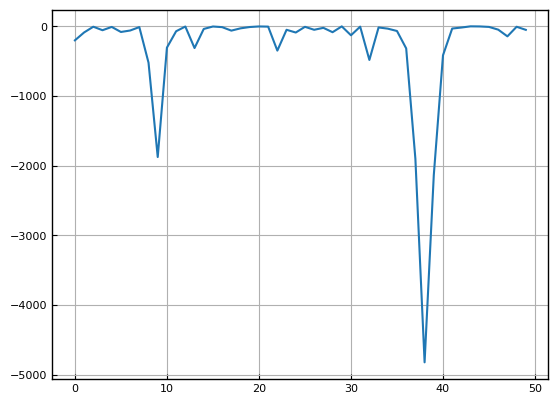

In [85]:
from scipy.signal import argrelextrema
from sklearn.neighbors import KernelDensity

# x = np.diff(a)
x = np.array(change_points, dtype=int)
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(x.reshape(-1, 1))
minval, maxval = 0, dataset.shape[0]-1
s = np.linspace(minval, maxval)
e = kde.score_samples(s.reshape(-1, 1))
# display(list(zip(b, e)))
plt.plot(e)

mi = argrelextrema(e, np.less)[0]

clusters = []
if len(mi) <= 0:
    print("1 cluster")
    clusters.append(np.arange(len(x)))
else:
    clusters.append(np.where(x < s[mi][0])[0])  # most left cluster
    # all middle cluster
    for i_cluster in range(len(mi)-1):
        clusters.append(np.where((x >= s[mi][i_cluster]) * (x <= s[mi][i_cluster+1]))[0])
    clusters.append(np.where(x >= s[mi][-1])[0])  # most right cluster

print(clusters) 
x_indice_to_cluster_id = {x_indice: cluster_id for cluster_id, x_indices in enumerate(clusters) for x_indice in x_indices}
cluster_labels = np.array([x_indice_to_cluster_id[x_indice] for x_indice in range(len(x))])
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, cluster_labels, x), columns=["metric", "cluster_id", "change_point"]).sort_values("change_point"))
cluster_id_to_metrics = {cluster_id: [metrics[x_indice] for x_indice in x_indices] for cluster_id, x_indices in enumerate(clusters)}

In [81]:
cluster_selection_epsilon = 3.0
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric=lambda x, y: np.abs(x - y),
    allow_single_cluster=True,
    cluster_selection_method="leaf",
    cluster_selection_epsilon=cluster_selection_epsilon,
).fit(np.array([change_points]).T)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, clusterer.labels_, change_points, clusterer.outlier_scores_, clusterer.probabilities_), columns=["metric", "cluster_id", "change_point", "outlier_score", "probability"]))
print("persistence", clusterer.cluster_persistence_)


from dataclasses import dataclass
from collections import UserList


@dataclass
class ClusterMember:
    metric_name: str
    change_point: int
    proba: float

@dataclass
class Cluster:
    cluster_id: int  # -1 means a noise cluster
    centroid: int  # -1 means a noise cluster
    members: list[ClusterMember]

    @classmethod
    def from_raw_members(cls, cluster_id: int, centroid: int, members: list[tuple[str, int, float]]):
        return cls(cluster_id, centroid, [ClusterMember(*member) for member in members])

    def _has_near_members(self, target: ClusterMember, eps: int) -> bool:
        _members = sorted(self.members, key=lambda m: m.change_point)
        for _member in _members:
            if _member.change_point == target.change_point:
                continue
            if abs(_member.change_point - target.change_point) < eps:
                return True
        return False

    def _inliers(self, threshold: float = 0.0, eps: int = 1) -> list[ClusterMember]:
        assert 0 <= threshold <= 1
        return [m for m in self.members if m.proba >= threshold or self._has_near_members(m, eps)]
    
    def keep_only_inliers(self, threshold: float, eps: int) -> None:
        self.members = self._inliers(threshold, eps)
    
    def size(self) -> int:
        return len(self.members)


class Clusters(UserList[Cluster]):
    def __init__(self, clusters: list[Cluster]):
        super().__init__(UserList(clusters))

    @classmethod
    def from_raw_values(cls, clusterer: hdbscan.HDBSCAN, metrics: list[str], change_points: list[int]):
        _cluster_id_to_centroid = {
            cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
            for cluster_id in np.unique(clusterer.labels_)
            if cluster_id != -1  # skip noise cluster
        }
        _cluster_id_to_members = defaultdict(list)
        for label, metric, change_point, proba in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
            centroid: int = _cluster_id_to_centroid.get(label, -1)  # -1 means a noise cluster
            _cluster_id_to_members[(label, centroid)].append((metric, change_point, proba))

        clusters: list[Cluster] = []
        for (cluster_id, centroid), members in sorted(_cluster_id_to_members.items(), key=lambda x: x[0][1]):
            clusters.append(Cluster.from_raw_members(cluster_id, centroid, members))
        return Clusters(clusters)
    
    def inliner(self, threshold: float = 1.0, eps: int = 1, copy: bool = True):
        if copy:
            _orig_clusters = self.data
            return Clusters([Cluster(c.cluster_id, c.centroid, c._inliers(threshold=threshold, eps=eps)) for c in _orig_clusters if c.cluster_id != -1])
        else:
            for c in self:
                if c.cluster_id == -1:
                    self.data.remove(c)
                    continue
                c.keep_only_inliers(threshold=threshold, eps=eps)
            return self
    
    def cluster_of_max_size(self) -> Cluster:
        return max(self, key=lambda c: c.size())
    
    def noise(self) -> Cluster:
        return next(c for c in self.data if c.cluster_id == -1)
    

# cluster_id_to_centroid = {
#     cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
#     for cluster_id in np.unique(clusterer.labels_)
#     if cluster_id != -1  # skip noise cluster
# }
# cluster_id_to_change_points: dict[int, list[int]] = defaultdict(list)
# clusters_with_centroid: dict[tuple[int, int], list[str]] = defaultdict(list)
# # print(list(zip(clusterer.labels_, metrics, change_points)))
# for cluster_id, metric, change_point, proba in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
#     if cluster_id == -1:  # skip noise features
#         continue
#     centroid = cluster_id_to_centroid[cluster_id]
#     clusters_with_centroid[(cluster_id, centroid)].append(metric)
#     cluster_id_to_change_points[cluster_id].append(change_point)

# remove outliers
# for (cluster_id, centroid), members in clusters_with_centroid.items():
#     if proba <= 0.5 and :
#         continue
# # choose a cluster having max metrics and the adjacent clusters
# import pprint
# for x in clusters_with_centroid.items():
#     print(agglomerative_coefficient(np.array(cluster_id_to_change_points[x[0][0]], dtype=int), x[0][1]), x)

clusters = Clusters.from_raw_values(clusterer, metrics, change_points)
inliners = clusters.inliner(threshold=0.5, eps=int(cluster_selection_epsilon), copy=True)
# keep_clusters = [inliners.cluster_of_max_size()]
# print("keep_clusters", keep_clusters)

# keep_metrics: list[str] = [m.metric_name for m in keep_clusters[0].members]
# remove_metrics: list[str] = list(set(metrics) - set(keep_metrics))
# clustering_info: dict[str, list[str]] = {metric: [] for metric in keep_metrics}
# clustering_info, remove_metrics

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/hdbscan/hdbscan_.py:1379: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


,metric,cluster_id,change_point,outlier_score,probability
0,c-carts-db_cpu_user_seconds_total,0,5,0.00,1.0
1,c-carts-db_memory_working_set_bytes,14,90,0.00,1.0
2,c-carts-db_cpu_cfs_periods_total,2,165,0.00,1.0
3,c-carts-db_cpu_usage_seconds_total,0,5,0.00,1.0
4,c-carts-db_memory_mapped_file,14,106,0.00,1.0
5,c-carts-db_memory_rss,14,94,NaN,1.0
6,c-carts-db_fs_reads_total,2,161,0.00,1.0
7,c-carts-db_network_transmit_bytes_total,3,175,0.00,1.0
8,c-carts-db_fs_writes_bytes_total,0,5,0.00,1.0
9,c-carts-db_network_transmit_packets_total,3,175,0.00,1.0


persistence [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [82]:
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d

eps = 2/dataset.shape[0]
a = np.sort(change_points)
vfunc = np.vectorize(lambda x: 0 if x/dataset.shape[0] <= eps else x)
diff = vfunc(np.diff(a))
print("diff", diff)
# rel_diff = [diff[i]/a[i] for i in range(len(diff))]
# smoothed_a = interp1d(x=np.arange(0, len(diff)), y=diff, kind="cubic")(np.arange(0, len(diff)))
# plt.plot(smoothed_a)
seg_indices = argrelextrema(diff, np.greater)[0] + 2
if abs(diff[0] - diff[1])/dataset.shape[0] > eps:
    seg_indices = np.append(seg_indices, 1)
if abs(diff[-1] - diff[-2])/dataset.shape[0] > eps:
    seg_indices = np.append(seg_indices, len(diff))
seg_indices = np.sort(seg_indices)
print("segment", seg_indices)

cluster_labels = []
for label, clusters in enumerate(np.split(a, seg_indices)):
    for _ in clusters:
        cluster_labels.append(label)
print(cluster_labels)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, cluster_labels, a), columns=["metric", "cluster_id", "change_point"]))

diff [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  6
  0  0  0  0  0  0 13  0  0  5  0  0  0  0  0  7  0  3  0  0  0  0  0  0
  0  0  0  0  4  0  0  0  4  0  0  4  0  0  0  6  0  4  0  0  0  0  0  0
  0  0  0  0  0  0  3  0  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  7  0  3
  0  0  0  4 20  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

,metric,cluster_id,change_point
0,c-carts-db_cpu_user_seconds_total,0,2
1,c-carts-db_memory_working_set_bytes,1,2
2,c-carts-db_cpu_cfs_periods_total,1,5
3,c-carts-db_cpu_usage_seconds_total,2,5
4,c-carts-db_memory_mapped_file,2,5
5,c-carts-db_memory_rss,2,5
6,c-carts-db_fs_reads_total,2,5
7,c-carts-db_network_transmit_bytes_total,2,5
8,c-carts-db_fs_writes_bytes_total,2,5
9,c-carts-db_network_transmit_packets_total,2,5


0 (0, 3)
1 (3, 6)
2 (6, 14)
3 (14, 16)
4 (16, 18)
5 (18, 24)
6 (24, 26)
7 (26, 40)
8 (40, 46)
9 (46, 53)
10 (53, 56)
11 (56, 58)
12 (58, 60)
13 (60, 62)
14 (62, 66)
15 (66, 70)
16 (70, 72)
17 (72, 74)
18 (74, 78)
19 (78, 84)
20 (84, 86)
21 (86, 91)
22 (91, 94)
23 (94, 102)
24 (102, 105)
25 (105, 109)
26 (109, 114)
27 (114, 121)
28 (121, 124)
29 (124, 126)
30 (126, 130)
31 (130, 150)
32 (150, 156)
33 (156, 159)
34 (159, 162)
35 (162, 167)
36 (167, 171)
37 (171, 176)
38 (176, 179)
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

,metric,cluster_id,change_point
0,c-carts-db_cpu_user_seconds_total,0,2
1,c-carts-db_memory_working_set_bytes,0,2
2,c-carts-db_cpu_cfs_periods_total,1,5
3,c-carts-db_cpu_usage_seconds_total,1,5
4,c-carts-db_memory_mapped_file,1,5
5,c-carts-db_memory_rss,1,5
6,c-carts-db_fs_reads_total,1,5
7,c-carts-db_network_transmit_bytes_total,1,5
8,c-carts-db_fs_writes_bytes_total,1,5
9,c-carts-db_network_transmit_packets_total,1,5


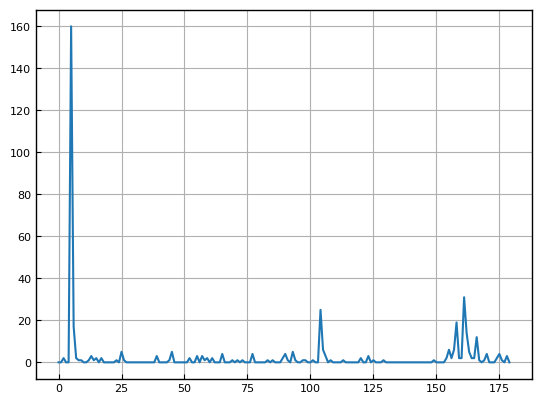

In [83]:
a = np.sort(np.array(change_points, dtype=int))

b = np.zeros(dataset.shape[0], dtype=int)
for i in range(b.size):
    indices = [_ for _ in a if _ == i]
    b[i] = len(indices)

plt.plot(b)
seg_indices = argrelextrema(b, np.greater)[0] + 1

cluster_labels = []
for label, indice in enumerate(seg_indices):
    if label == 0:
        left = 0
    else:
        left = seg_indices[label - 1]
    right = seg_indices[label]
    print(label, (left, right))
    clusters = np.where((a >= left) & (a < right))[0]
    for _ in clusters:
        cluster_labels.append(label)
print(cluster_labels)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, cluster_labels, a), columns=["metric", "cluster_id", "change_point"]))

In [84]:
reshape(-1, 1))
print(len(x), e.shape)
# display(list(zip(b, e)))
plt.plot(e)

mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print(mi, ma)

if len(mi) + len(ma) <= 1:
    print("1 cluster")
else:
    print(x[x < s[mi][0]])  # print most left cluster
    # print all middle cluster
    for i_cluster in range(len(mi)-1):
        print(x[(x >= s[mi][i_cluster]) * (x <= s[mi][i_cluster+1])])
    print(x[x >= s[mi][-1]])  # print most right cluster

SyntaxError: unmatched ')' (3275153832.py, line 1)

AttributeError: 'str' object has no attribute 'change_point'

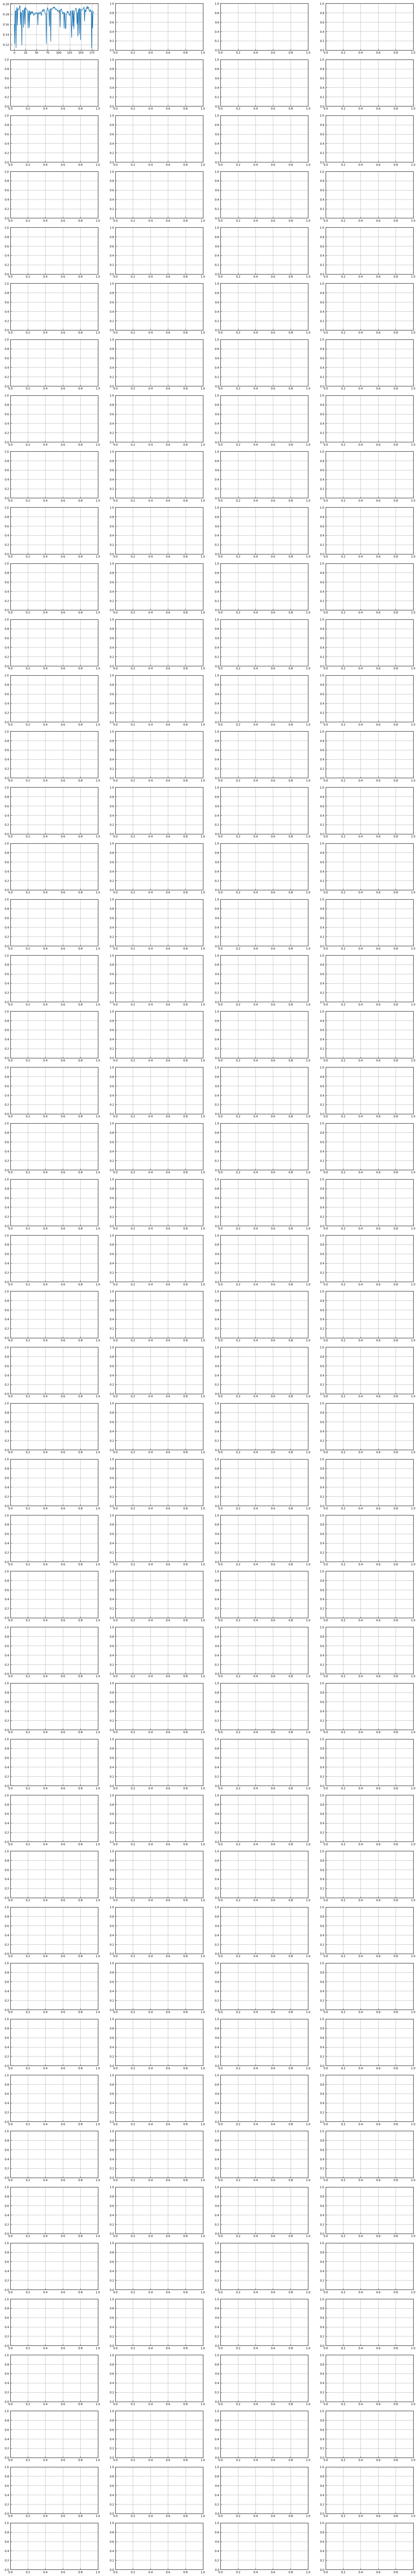

In [88]:
import math
from notebooklib import plot

plt.close()

for cluster_id, metrics in cluster_id_to_metrics.items():
    fig, axs = plt.subplots(math.ceil(len(metrics)/4), ncols=4)
    fig.set_size_inches(20, 0.7*len(metrics))
    for ax, member in zip(axs.flatten(), metrics):
        metric = member
        x = cause_dataset[metric].to_numpy()
        ax.plot(x)
        bkp = metric_to_bkp[metric]
        ax.axvline(bkp, color='red', alpha=0.5)
        ax.set_title(f"{cluster_id}:{metric}:{bkp}")